In [18]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from matplotlib.ticker import MaxNLocator
from decimal import Decimal, ROUND_HALF_UP
from xgboost import XGBClassifier

# Notes of things Xuanthe's worked on
* Reworded the Data Imbalance section
* Fixed the EDA

# NOTES OF THINGS TO WORK ON
* There are notes scattered throughout in all caps, usually in a larger markdown font. Most is smaller stuff or stuff I'm confused by
* Our missingness treatment of dropping all teams might not be great anymore, there are 14 dropped teams, and some only have 1 or a few missing values. I doubt we adjust at this point but worth considering
* I moved Conrad's EDA later in the notebook (as seen in the contents). That EDA, as well as the "High-level summary of Data" is not great because it doesn't use the actual final dataframes, which are `regular_proc_df' and `NCAA_proc'. If someone could bite the bullet and do good EDA on the actual final constructed dataframes, that would probably be ideal, but if not let's make sure we justify what we are doing in those sections. It's important to note that the stuff that creates the perset_df in the High-level summary of Data" cannot be removed because its necessary during the scraping parts
* As you can prob tell based on the last bullet, the overall organization is a mess and could use work, any changes should be reflected in the contents. As of this commit that contents is correct
* Implementation of a Random forest (I don't think we can just go right from a logistic regression to a XGBoost, they aren't really comparable models)
* Improving implementation of all models
* Note that as of now I am just going to use regular season matches to generate my train val split, and use the ncaa tournament as a test set. I don't know if this is valid, but we can ask our TF. My alterations to the splitting might have broken some of the models
Plus I think you can do anything you want with test set tbh 
* A good final discussion comparing the results of the models

<a id="contents"></a>
# Contents
1. [**Introduction**](#introduction)
    - [**Problem Statement & Overarching Question**](#prob)
    - [**Data Scraping & Storage**](#scrape)
2. [**Exploratory Data Analysis**](#eda)
    - [**High-level Summary of Data**](#summary)
    - [**Preprocessing**](#preprocess)
        - [**Missing Data**](#missing)
        - [**Data Imbalance**](#imbalance)
        - [**Data Scaling**](#scaling)
    - [**Win-loss Scraping**](#more-scraping)
    - [**Calculating Feature Significance vs Set Win Percentage**](#calc-feature)
3. [**Further Preprocessing**](#further-preprocessing)
    - [**Class Imbalance**](#add-preprocess)
    - [**Merging Match Data with Season Stats**](#merging)
    - [**Separating out Tournament Matches**](#separating)
    

    - [**CONRAD EDA Visualizing Features vs Set Win Percentage (Scatter)**](#vis-features-scatter)
    - [**CONRAD EDA Visualizing Features vs Set Win Percentage (Histograms and Boxplots)**](#vis-features-histogram)
    - [**Split Train / Test Data**](#step1)
4. [**Modeling**](#modelling)
    - [**Baseline Model (Majority Class)**](#step2)
    - [**Basic Model (Logistic Regression)**](#step3)
        - [**Results Interpretation**](#interp)
    - [**Random Forest Model**](#step4)
    - [**Final Model Pipeline (XGBoost)**](#step5)

<a id="intro"></a>
# 1. Introduction

<a id="prob"></a>

## Problem Statement & Overarching Question
[Return to contents](#contents)

Each autumn, over 300 NCAA Division I women’s volleyball teams compete to win a national championship.  A season consists of a regular season and the NCAA tournament.  During the regular season, each team competes in roughly 30 matches.  At the end of the regular season, the top 64 teams vie for the NCAA tournament, a single elimination bracket culminating in the National Championship match. All four members of this team are members of the Harvard Men's Volleyball Team, so we are deeply interested in the outcomes of this tournament and whether we can predict them.

Many other fans across the country will also make predictions. As both women’s volleyball and sports betting have gained popularity in recent years, it has become common practice to enter playoff bracket pools, where individuals select the winner for each match in the tournament, with each round awarding more points for correct selections, and the winner being the individual with the most cumulative points over the course of the tournament. In addition, sportsbooks will publish odds for fans to bet on for every matchup that takes place during this period. 

This year, tournament play will begin on December 5th, meaning the first three rounds (56 out of the 63 total matches) will have taken place before our final report is due on December 16th. Thus, our final research question is: for how many of the 56 available NCAA tournament games played can we accurately predict the winner using a model based on the current regular season team statistics? And who will be the champion?

Using the techniques we learned in class, we aim to build a classification model to help us answer this question. We will train, validate, and test on matchup data and season statistics from the 2024 regular season, then provide probabilites of winning for each tournament matchup, ultimately using those results to help us predict the winner of the 64 team tournament. Then we could begin asking other questions such as which teams will make it to the Final 4 and so on.


<a id="scrape"></a>
## Data Scraping and Storage
[Return to contents](#contents)

The following code scrapes the 2024 NCAA Division I women's volleyball team statistics so far for this season from "https://www.ncaa.com." The data is stored to a local csv called finalized_data.csv to avoid constant rescraping. Occasional rescraping is warranted given that more games occur as we continue to work on this project.

In [19]:
rescrape_reg_season_stats = False
rescrape_win_loss = False
rescrape_team_names = False

In [20]:
base_stat_url = "https://www.ncaa.com"

if rescrape_reg_season_stats:
    # Stats and their corresponding URL endings
    stat_endpoints = {
        "Hitting Percentage": "/stats/volleyball-women/d1/current/team/45",
        "Aces Per Set": "/stats/volleyball-women/d1/current/team/48",
        "Assists Per Set": "/stats/volleyball-women/d1/current/team/47",
        "Blocks Per Set": "/stats/volleyball-women/d1/current/team/49",
        "Digs Per Set": "/stats/volleyball-women/d1/current/team/50",
        "Kills Per Set": "/stats/volleyball-women/d1/current/team/46",
        "Match W-L Pctg.": "/stats/volleyball-women/d1/current/team/51",
        "Opp Hitting Percentage": "/stats/volleyball-women/d1/current/team/911",
        "Team Assists": "/stats/volleyball-women/d1/current/team/882",
        "Team Attacks Per Set": "/stats/volleyball-women/d1/current/team/892",
        "Team Digs": "/stats/volleyball-women/d1/current/team/886",
        "Team Kills": "/stats/volleyball-women/d1/current/team/881",
        "Team Service Aces": "/stats/volleyball-women/d1/current/team/884",
        "Team Total Attacks": "/stats/volleyball-women/d1/current/team/891",
        "Team Total Blocks": "/stats/volleyball-women/d1/current/team/888"
    }

    combined_df = pd.DataFrame()

    for stat, endpoint in stat_endpoints.items():
        # Get the page
        url = f"{base_stat_url}{endpoint}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Check the page selector section to see how many total pages
        pages = soup.select(".stats-pager__li a")
        total_pages = max([int(page.text) for page in pages if page.text.isdigit()])

        # Loop through all pages for each statistic
        stat_df = pd.DataFrame()
        for page in range(1, total_pages + 1):
            url = f"{base_stat_url}{endpoint}/p{page}" if page > 1 else f"{base_stat_url}{endpoint}"

            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Get stat header and exclude rank
            headers = [header.text.strip() for header in soup.select("thead th")][1:]
            headers[1:] = [f"{header} ({stat})" for header in headers[1:]]

            # Get stats
            data = {header: [] for header in headers}
            for row in soup.select("tbody tr"):
                cells = row.find_all("td")[1:]  # Skip the rank cell
                for i, cell in enumerate(cells):
                    data[headers[i]].append(cell.text.strip())

            page_df = pd.DataFrame(data)
            stat_df = pd.concat([stat_df, page_df], ignore_index=True)

        # Merge the stat with the existing data
        if combined_df.empty:
            combined_df = stat_df
        else:
            combined_df = pd.merge(combined_df, stat_df, on="Team", how="outer")

    # Selecting relevant columns
    finalized_df = combined_df[['Team', 'S (Hitting Percentage)', 'Kills (Hitting Percentage)',
        'Errors (Hitting Percentage)', 'Total Attacks (Hitting Percentage)',
        'Pct. (Hitting Percentage)', 'Aces (Aces Per Set)',
        # 'Per Set (Aces Per Set)',
        'Assists (Assists Per Set)', # 'Per Set (Assists Per Set)',
        'Block Solos (Blocks Per Set)',
        'Block Assists (Blocks Per Set)', #'Per Set (Blocks Per Set)',
        'Digs (Digs Per Set)', #'Per Set (Digs Per Set)',
        # 'Per Set (Kills Per Set)',
        'W (Match W-L Pctg.)', 'L (Match W-L Pctg.)', 'Pct. (Match W-L Pctg.)',
        'Opp Kills (Opp Hitting Percentage)',
        'Opp Errors (Opp Hitting Percentage)',
        'Opp Attacks (Opp Hitting Percentage)',
        'Opp Pct (Opp Hitting Percentage)',
        # 'Per Set (Team Attacks Per Set)',
        'TB (Team Total Blocks)']].copy()

    # Renaming Columns
    column_renames = {
        'S (Hitting Percentage)': 'Sets Played',
        'Kills (Hitting Percentage)': 'Kills',
        'Errors (Hitting Percentage)': 'Errors',
        'Total Attacks (Hitting Percentage)': 'Total Attacks',
        'Pct. (Hitting Percentage)': 'Hit Percentage',
        'Aces (Aces Per Set)': 'Aces',
        'Assists (Assists Per Set)': 'Assists',
        'Block Solos (Blocks Per Set)': 'Block Solos',
        'Block Assists (Blocks Per Set)': 'Block Assists',
        'Digs (Digs Per Set)': 'Digs',
        'W (Match W-L Pctg.)': 'Wins',
        'L (Match W-L Pctg.)': 'Losses',
        'Pct. (Match W-L Pctg.)': 'Win Percentage',
        'Opp Kills (Opp Hitting Percentage)': 'Opponent Kills',
        'Opp Errors (Opp Hitting Percentage)': 'Opponent Errors',
        'Opp Attacks (Opp Hitting Percentage)': 'Opponent Total Attacks',
        'Opp Pct (Opp Hitting Percentage)': 'Opponent Hit Percentage',
        'TB (Team Total Blocks)': 'Total Blocks'
    }

    # Renaming columns in our dataframe
    finalized_df.rename(columns=column_renames, inplace=True)

    # Save to CSV file 
    finalized_df.to_csv("data/finalized_data.csv", index=False)

else:
    finalized_df = pd.read_csv("data/finalized_data.csv")

<a id="eda"></a>
# 2. Exploratory Data Analysis

<a id="summary"></a>
## High-level Summary of Data
[Return to contents](#contents)

This observations for this data set are women's collegiate volleyball teams that compete in NCAA Divison I. From our dataset—which can be seen below—we can obtain the predictors we will use in our eventual model, such as number of wins, number of losses, team hitting percentage, opponent hitting percentage, and many more.

In [21]:
# Inspect the data
finalized_df.head(5)

,Team,Sets Played,Kills,Errors,Total Attacks,Hit Percentage,Aces,Assists,Block Solos,Block Assists,Digs,Wins,Losses,Win Percentage,Opponent Kills,Opponent Errors,Opponent Total Attacks,Opponent Hit Percentage,Total Blocks
0,A&M-Corpus Christi,110.0,1538.0,455.0,4025.0,0.269,138.0,1434.0,70.0,209.0,1803.0,20.0,11.0,0.645,1422.0,521.0,3970.0,0.227,174.5
1,Abilene Christian,101.0,1198.0,629.0,3567.0,0.160,140.0,1105.0,36.0,236.0,1419.0,10.0,18.0,0.357,1217.0,489.0,3372.0,0.216,154.0
2,Air Force,101.0,1090.0,578.0,3470.0,0.148,123.0,990.0,44.0,292.0,1293.0,3.0,26.0,0.103,1422.0,525.0,3500.0,0.256,190.0
3,Akron,122.0,1600.0,630.0,4364.0,0.222,207.0,1530.0,28.0,403.0,1786.0,11.0,19.0,0.367,1581.0,595.0,4209.0,0.234,229.5
4,Alabama,103.0,1302.0,565.0,3560.0,0.207,145.0,1208.0,22.0,326.0,1359.0,11.0,16.0,0.407,1354.0,462.0,3466.0,0.257,185.0


In [22]:
finalized_df.shape

(338, 19)

In [23]:
finalized_df.describe()

,Sets Played,Kills,Errors,Total Attacks,Hit Percentage,Aces,Assists,Block Solos,Block Assists,Digs,Wins,Losses,Win Percentage,Opponent Kills,Opponent Errors,Opponent Total Attacks,Opponent Hit Percentage,Total Blocks
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,110.041916,1376.814371,572.290419,3840.556886,0.208710,165.733533,1277.568862,52.949102,353.883234,1613.541916,14.991018,14.479042,0.501491,1368.724551,575.736527,3841.056886,0.207485,229.922156
std,10.242321,195.182663,72.803220,428.102512,0.039541,30.618023,182.025837,17.904999,89.200426,234.201749,6.482819,5.414183,0.196642,144.664660,79.304500,441.796822,0.027578,48.635093
min,73.000000,696.000000,397.000000,2258.000000,0.116000,95.000000,634.000000,12.000000,100.000000,898.000000,1.000000,1.000000,0.038000,796.000000,290.000000,2081.000000,0.123000,116.000000
25%,103.000000,1260.250000,520.250000,3563.750000,0.183000,146.000000,1167.250000,40.000000,296.000000,1443.250000,10.000000,11.000000,0.357000,1275.000000,517.250000,3535.500000,0.190000,198.625000
50%,111.000000,1392.000000,570.000000,3866.500000,0.208000,163.000000,1286.000000,51.000000,348.000000,1614.500000,15.000000,14.000000,0.500000,1385.000000,578.000000,3848.500000,0.208000,226.500000
75%,117.000000,1521.000000,618.000000,4113.500000,0.232000,184.000000,1414.500000,63.000000,420.250000,1756.750000,19.000000,18.000000,0.646500,1459.750000,628.000000,4106.750000,0.225000,263.000000
max,136.000000,1857.000000,807.000000,4919.000000,0.336000,263.000000,1731.000000,131.000000,618.000000,2281.000000,31.000000,26.000000,0.969000,1778.000000,840.000000,5017.000000,0.286000,364.000000


In [24]:
finalized_df.isna().sum()

Team                       0
Sets Played                4
Kills                      4
Errors                     4
Total Attacks              4
Hit Percentage             4
Aces                       4
Assists                    4
Block Solos                4
Block Assists              4
Digs                       4
Wins                       4
Losses                     4
Win Percentage             4
Opponent Kills             4
Opponent Errors            4
Opponent Total Attacks     4
Opponent Hit Percentage    4
Total Blocks               4
dtype: int64

# NEEDS ATTENTION, THE MISSING VALUE SITUATION IS NOW MORE COMPLICATED, FOR NOW STILL GOING TO DROP EVERYTHING

In [25]:
teams_with_missing_values = finalized_df[finalized_df.isna().any(axis=1)]

for index, row in teams_with_missing_values.iterrows():
    team = row['Team']
    missing_count = row.isna().sum() 
    print(f"Team: {team}, Missing Values: {missing_count}")

Team: Alcorn, Missing Values: 15
Team: Gonzaga, Missing Values: 3
Team: Hampton, Missing Values: 14
Team: Idaho, Missing Values: 8
Team: Manhattan, Missing Values: 3
Team: Marist, Missing Values: 2
Team: Mercyhurst, Missing Values: 1
Team: Mississippi Val., Missing Values: 4
Team: Morgan St., Missing Values: 1
Team: Murray St., Missing Values: 1
Team: New Orleans, Missing Values: 12
Team: Ohio, Missing Values: 1
Team: South Carolina St., Missing Values: 6
Team: Western Caro., Missing Values: 1


<a id="preprocess"></a>
## Preprocessing
[Return to contents](#contents)

## CORRECT THIS BASED ON WHAT WE DECIDE TO DO with missingness above

<a id="missing"></a>
### Missing Data

Four out of the 338 teams in the data set (as of the time of writing) only had a win loss record, and no other statistics. These teams all ranked near the bottom in terms of win-loss record. Considering the minimal extent of this missingness, we decided that it made better sense to **delete these four rows altogether and exclude them from our prediction model**. The code to perform this removal can be seen below.


In [26]:
finalized_df.dropna(inplace=True)
finalized_df.reset_index(drop=True, inplace=True)
finalized_df.shape


(324, 19)

In [27]:
finalized_df['Sets Played'].dtypes

dtype('float64')

<a id="imbalance"></a>
### Data Imbalance

# CORRECT THIS, THIS IS A CLASSIFICATION PROBLEM

Our eventual goal will involve determining which teams will win their games, so we are dealing with a classification problem instead of a regression problem. However, resampling techniques or class weighting won't be necessary because this is a "closed-loop" season. In other words, the total wins will equal the total losses, which limits the chance of a majority class of winners or losers arising.


<a id="scaling"></a>
### Data Scaling
Though teams play a similar number of matches throughout the season, they do not necessarily play the same number of sets, since volleyball matches are best-of-5. Also, certain stats categories (features) are more frequent than others in a typical volleyball match, for example, kills are more common than blocks. Because of this, the cumulative statistics in this data set vary widely in their scale of values.  To address this, we processed as many of these categories as we could into new features, which are all "per-set" values (kills-per-set, blocks-per-set, etc.). This scales these values to be comparable between teams who have played a different number of sets, but additional scaling may be necessary moving forward. Furthermore, some metrics are efficiencies, represented in percentages between 0 and 1, while others are integral numeric values, greater than zero.  It may behoove us to normalize the integral value features such that they are expressed in relative terms at the same scale as the percentages.



## DO WE STILL WANT TO DROP THE OG COLUMNS? Remove the coerce thing


In [28]:
if rescrape_reg_season_stats:
    # List of columns to convert to per-set values
    toperset = [
        'Kills', 'Errors', 'Total Attacks', 'Aces', 'Assists',
        'Block Solos', 'Block Assists', 'Total Blocks', 'Digs',
        'Opponent Kills', 'Opponent Errors', 'Opponent Total Attacks'
    ]

    perset_df = finalized_df.copy()
    # perset_df['Sets Played'] = pd.to_numeric(perset_df['Sets Played'])

    # Convert to per-set values
    for col in toperset:
        # perset_df[col] = pd.to_numeric(perset_df[col], errors='coerce')

        perset_df[f'{col} Per Set'] = perset_df[col] / perset_df['Sets Played']

    # Drop the original columns 
    perset_df.drop(columns=toperset, inplace=True)

    perset_df.to_csv("data/perset_data.csv", index=False)
else:
    perset_df = pd.read_csv("data/perset_data.csv")




<a id="more-scraping"></a>
## Additional Scraping
[Return to contents](#contents)

We are now going to scrape from a new source and create a final DataFrame, which will include all of our desired predictors and response variable.


 **This gets regular season and tournament win loss, so we need to split after the fact. More efficient than repeating the same scraping code over again later for tournament stuff**

In [29]:
if rescrape_win_loss:
    #  Function to check if games exist on the page
    def check_for_games(soup):
        no_games_element = soup.find("div", class_="gamePod_content")
        return no_games_element is None or "No games" not in no_games_element.text

    # Start date (August 1st)
    start_date = datetime(2024, 8, 1)
    # End date (yesterday)
    end_date = datetime.now() - timedelta(days=1)

    # Initialize an empty DataFrame to store all game results
    all_games_df = pd.DataFrame(columns=["Date", "Winner", "Winner Score", "Loser", "Loser Score"])

    # Loop through each day
    current_date = start_date
    while current_date <= end_date:
        # Format the date as YYYY/MM/DD
        date_str = current_date.strftime("%Y/%m/%d")
        url = f"https://www.ncaa.com/scoreboard/volleyball-women/d1/{date_str}"
        
        # Send the request and parse the page
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Check if there are games on this date
        if check_for_games(soup):
            games = soup.find_all("div", class_="gamePod")
            for game in games:
                teams = game.select(".gamePod-game-teams li")
                if len(teams) >= 2:  # Ensure there are both winner and loser data
                    # Extract team names
                    team1_name = teams[0].select_one(".gamePod-game-team-name").text.strip()
                    team2_name = teams[1].select_one(".gamePod-game-team-name").text.strip()
                    
                    # Extract and parse scores
                    team1_score_text = teams[0].select_one(".gamePod-game-team-score").text.strip()
                    team2_score_text = teams[1].select_one(".gamePod-game-team-score").text.strip()
                    
                    # Check if scores are valid numbers
                    if team1_score_text.isdigit() and team2_score_text.isdigit():
                        team1_score = int(team1_score_text)
                        team2_score = int(team2_score_text)
                        
                        # Determine the winner and loser based on scores
                        if team1_score > team2_score:
                            winner, winner_score = team1_name, team1_score
                            loser, loser_score = team2_name, team2_score
                        else:
                            winner, winner_score = team2_name, team2_score
                            loser, loser_score = team1_name, team1_score
                        
                        # Append the game data to the DataFrame
                        all_games_df = pd.concat([all_games_df, pd.DataFrame({
                            "Date": [current_date.strftime("%Y-%m-%d")],
                            "Winner": [winner],
                            "Winner Score": [winner_score],
                            "Loser": [loser],
                            "Loser Score": [loser_score]
                        })], ignore_index=True)
        
        # Move to the next day
        current_date += timedelta(days=1)
    
    # Save the DataFrame to a CSV file
    all_games_df.to_csv("data/all_games.csv", index=False)

else:
    all_games_df = pd.read_csv("data/all_games.csv")


# 3. Further Proprocessing
[Return to contents](#contents)
<a id="further-preprocesssing"></a>


## Class Imbalance
[Return to contents](#contents)
<a id="add-preprocess"></a>

Below, we amend the all_games_df to no longer use "winners" and "losers", but now "Team 1" and "Team 2." This is so that we don't have total class imbalance with what will end up being our target, the Win_Indicator variable. We randomly swap, stratifying so that 50% of the set is Team 1 wins and 50% of the set is Team 2 wins.

Win_Indicator = 1 indicates that Team 1 won the match and vice versa.

In [30]:
np.random.seed(27)  # Set seed for reproducibility

# Rename columns for Team 1 and Team 2
all_games_df = all_games_df.rename(columns={
    'Winner': 'Team 1',
    'Loser': 'Team 2',
    'Winner Score': 'Team 1 Score',
    'Loser Score': 'Team 2 Score'
})

# Randomly swap 50% of the Team 1 and Team 2 columns to get even split on target variables (Wins and Losses)
display(all_games_df.head(10)) # See the motivation behind swap; Team 1 right now wins all of the games
swap_mask = np.random.rand(len(all_games_df)) < 0.5 # Determine which ones to swap

# Swap Team 1 and Team 2 for selected rows
columns_to_swap = ['Team 1', 'Team 1 Score', 'Team 2', 'Team 2 Score']
for col1, col2 in zip(columns_to_swap[:2], columns_to_swap[2:]):
    all_games_df.loc[swap_mask, [col1, col2]] = all_games_df.loc[swap_mask, [col2, col1]].values

# Calculate Win_Indicator based on swapped columns
all_games_df['Win_Indicator'] = (all_games_df['Team 1 Score'] > all_games_df['Team 2 Score']).astype(int)

# Display the df, with even number of Team 1 and Team 2 'wins' / having a score of 3
all_games_df.head(10)


,Date,Team 1,Team 1 Score,Team 2,Team 2 Score
0,2024-08-25,New Mexico St.,3,Western N.M.,0
1,2024-08-26,Charleston So.,3,Anderson (SC),1
2,2024-08-27,Nebraska,3,Kentucky,1
3,2024-08-27,Louisville,3,Wisconsin,1
4,2024-08-30,Nicholls,3,South Carolina St.,1
5,2024-08-30,Stony Brook,3,Delaware St.,2
6,2024-08-30,Norfolk St.,3,Gardner-Webb,0
7,2024-08-30,SIUE,3,Eastern Mich.,0
8,2024-08-30,Coppin St.,3,Northeastern,0
9,2024-08-30,Quinnipiac,3,Rhode Island,2


,Date,Team 1,Team 1 Score,Team 2,Team 2 Score,Win_Indicator
0,2024-08-25,Western N.M.,0,New Mexico St.,3,0
1,2024-08-26,Charleston So.,3,Anderson (SC),1,1
2,2024-08-27,Nebraska,3,Kentucky,1,1
3,2024-08-27,Louisville,3,Wisconsin,1,1
4,2024-08-30,South Carolina St.,1,Nicholls,3,0
5,2024-08-30,Stony Brook,3,Delaware St.,2,1
6,2024-08-30,Norfolk St.,3,Gardner-Webb,0,1
7,2024-08-30,Eastern Mich.,0,SIUE,3,0
8,2024-08-30,Coppin St.,3,Northeastern,0,1
9,2024-08-30,Quinnipiac,3,Rhode Island,2,1


## Merging Match Data with Season Stats
[Return to contents](#contents)
<a id="merging"></a>


Now that we have match data, we want to combine that DataFrame with our season stats dataframe. This requires careful merging

In [31]:
team1_perset_copy = perset_df.copy()
team1_perset_copy  = team1_perset_copy.add_prefix("Team_1:").rename(columns={"Team_1:Team": "Team"})
team2_perset_copy = perset_df.copy()
team2_perset_copy  = team2_perset_copy.add_prefix("Team_2:").rename(columns={"Team_2:Team": "Team"})

# Merge to get stats for team 1
all_games_with_team1_stats = all_games_df.merge(
    team1_perset_copy,
    how="left",
    left_on="Team 1",
    right_on="Team"  # Key for matching in team1_perset_copy
)

# Merge to get stats for team 2
all_games_with_both_stats = all_games_with_team1_stats.merge(
    team2_perset_copy,
    how="left",
    left_on="Team 2",
    right_on="Team"  # Key for matching in team2_perset_copy
)

# Drop extra columns
all_games_with_both_stats = all_games_with_both_stats.drop(columns=['Team_x', 'Team_y'])


# Drop NaN values which were reintroduced by the merge
# Drop missing values and reset index
all_games_with_both_stats.dropna(inplace=True)
all_games_with_both_stats.reset_index(drop=True, inplace=True)

all_games_with_both_stats.shape


(4490, 42)

## Separating out Tournament Matches
[Return to contents](#contents)
<a id="separating"></a>

Now we want to separate out the NCAA tournament games, this is difficult because there are many regular season games (according to our prior classification) that take place after the start date of the tournament. To separete into the sets we want, we will have to check both the date and the teams involved. We begin by getting the names of the 64 teams in the tournament. In the cell after we split into our two final dataframes using the aforementioned criteria

In [32]:
if rescrape_team_names:
    url = "https://www.ncaa.com/brackets/volleyball-women/d1/2024"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    teams = soup.find_all('span', class_='name')
    team_names = [team.text.strip() for team in teams]

    unique_teams = sorted(team_names)

    unique_teams_df = pd.DataFrame(unique_teams, columns=['Team'])
    unique_teams_df.to_csv('data/unique_teams.csv', index=False)
else:
    unique_teams_df = pd.read_csv('data/unique_teams.csv')
    unique_teams = unique_teams_df['Team'].tolist()

In [36]:

# Convert 'Date' column to datetime for comparison
all_games_with_both_stats['Date'] = pd.to_datetime(all_games_with_both_stats['Date'])

# Filter for NCAA tournament games
NCAA_proc_df = all_games_with_both_stats[
    (all_games_with_both_stats['Date'] > '2024-12-05') &  # Match date after 2024-12-05
    (all_games_with_both_stats['Team 1'].isin(unique_teams)) &  # Team 1 is in unique_teams
    (all_games_with_both_stats['Team 2'].isin(unique_teams))    # Team 2 is in unique_teams
]

# Filter for regular season games
reg_proc_df = all_games_with_both_stats[
    ~all_games_with_both_stats.index.isin(NCAA_proc_df.index)  # Exclude NCAA games
]


print(f"NCAA Tournament games (NCAA_proc_df): {NCAA_proc_df.shape}")
print(f"Regular season games (reg_proc_df): {reg_proc_df.shape}")

NCAA_proc_df.to_csv('data/NCAA_proc.csv', index=False)
reg_proc_df.to_csv('data/regular_proc.csv', index=False)


NCAA Tournament games (NCAA_proc_df): (30, 42)
Regular season games (reg_proc_df): (4460, 42)


In [56]:
display(reg_proc_df.columns)
reg_proc_df.head()

Index(['Date', 'Team 1', 'Team 1 Score', 'Team 2', 'Team 2 Score',
       'Win_Indicator', 'Team_1:Sets Played', 'Team_1:Hit Percentage',
       'Team_1:Wins', 'Team_1:Losses', 'Team_1:Win Percentage',
       'Team_1:Opponent Hit Percentage', 'Team_1:Kills Per Set',
       'Team_1:Errors Per Set', 'Team_1:Total Attacks Per Set',
       'Team_1:Aces Per Set', 'Team_1:Assists Per Set',
       'Team_1:Block Solos Per Set', 'Team_1:Block Assists Per Set',
       'Team_1:Total Blocks Per Set', 'Team_1:Digs Per Set',
       'Team_1:Opponent Kills Per Set', 'Team_1:Opponent Errors Per Set',
       'Team_1:Opponent Total Attacks Per Set', 'Team_2:Sets Played',
       'Team_2:Hit Percentage', 'Team_2:Wins', 'Team_2:Losses',
       'Team_2:Win Percentage', 'Team_2:Opponent Hit Percentage',
       'Team_2:Kills Per Set', 'Team_2:Errors Per Set',
       'Team_2:Total Attacks Per Set', 'Team_2:Aces Per Set',
       'Team_2:Assists Per Set', 'Team_2:Block Solos Per Set',
       'Team_2:Block Assists

,Date,Team 1,Team 1 Score,Team 2,Team 2 Score,Win_Indicator,Team_1:Sets Played,Team_1:Hit Percentage,Team_1:Wins,Team_1:Losses,...,Team_2:Total Attacks Per Set,Team_2:Aces Per Set,Team_2:Assists Per Set,Team_2:Block Solos Per Set,Team_2:Block Assists Per Set,Team_2:Total Blocks Per Set,Team_2:Digs Per Set,Team_2:Opponent Kills Per Set,Team_2:Opponent Errors Per Set,Team_2:Opponent Total Attacks Per Set
0,2024-08-27,Nebraska,3,Kentucky,1,1,110.0,0.290,31.0,2.0,...,33.417476,1.893204,13.048544,0.378641,3.475728,2.116505,12.407767,10.708738,5.038835,30.330097
1,2024-08-27,Louisville,3,Wisconsin,1,1,112.0,0.265,27.0,5.0,...,33.821429,1.571429,13.035714,0.339286,5.517857,3.098214,14.794643,11.982143,5.866071,35.428571
2,2024-08-30,Stony Brook,3,Delaware St.,2,1,119.0,0.203,16.0,13.0,...,35.034783,1.782609,11.513043,0.547826,2.069565,1.582609,13.808696,10.547826,4.373913,32.000000
3,2024-08-30,Norfolk St.,3,Gardner-Webb,0,1,101.0,0.211,13.0,15.0,...,37.224490,1.459184,9.887755,0.418367,2.193878,1.515306,16.714286,14.265306,4.734694,38.520408
4,2024-08-30,Eastern Mich.,0,SIUE,3,0,123.0,0.157,13.0,19.0,...,34.968000,1.464000,10.912000,0.792000,3.560000,2.572000,14.440000,13.384000,5.904000,36.352000


<a id="calc-feature"></a>
## Processing the `reg_proc_df` data for subsequent visualizations
[Return to contents](#contents)

`Set_Win_Percentage` is going to be our $y$ in the proceeding graphs to develop intuition for which predictors would be important in determining whether a team wins the game. We also defined a `Win_Category` ordinal variable in this step to help us with plotting the histograms and box plots after the scatter plot, but we won't use it in the modeling sections afterwards.

In [57]:
# Creating one unified data_set
unify_cols = {
    'Sets Played': ['Team_1:Sets Played', 'Team_2:Sets Played'],
    'Hit Percentage': ['Team_1:Hit Percentage', 'Team_2:Hit Percentage'],
    'Wins': ['Team_1:Wins', 'Team_2:Wins'],
    'Losses': ['Team_1:Losses', 'Team_2:Losses'],
    'Win Percentage': ['Team_1:Win Percentage', 'Team_2:Win Percentage'],
    'Opponent Hit Percentage': ['Team_1:Opponent Hit Percentage', 'Team_2:Opponent Hit Percentage'],
    'Kills Per Set': ['Team_1:Kills Per Set', 'Team_2:Kills Per Set'],
    'Errors Per Set': ['Team_1:Errors Per Set', 'Team_2:Errors Per Set'],
    'Total Attacks Per Set': ['Team_1:Total Attacks Per Set', 'Team_2:Total Attacks Per Set'],
    'Aces Per Set': ['Team_1:Aces Per Set', 'Team_2:Aces Per Set'],
    'Assists Per Set': ['Team_1:Assists Per Set', 'Team_2:Assists Per Set'],
    'Block Solos Per Set': ['Team_1:Block Solos Per Set', 'Team_2:Block Solos Per Set'],
    'Block Assists Per Set': ['Team_1:Block Assists Per Set', 'Team_2:Block Assists Per Set'],
    'Total Blocks Per Set': ['Team_1:Total Blocks Per Set', 'Team_2:Total Blocks Per Set'],
    'Digs Per Set': ['Team_1:Digs Per Set', 'Team_2:Digs Per Set'],
    'Opponent Kills Per Set': ['Team_1:Opponent Kills Per Set', 'Team_2:Opponent Kills Per Set'],
    'Opponent Errors Per Set': ['Team_1:Opponent Errors Per Set', 'Team_2:Opponent Errors Per Set'],
    'Opponent Total Attacks Per Set': ['Team_1:Opponent Total Attacks Per Set', 'Team_2:Opponent Total Attacks Per Set']
}

# Combine wins/losses into a single DataFrame
team_sets = pd.concat([
    reg_proc_df[['Team 1', 'Team 1 Score', 'Team 2 Score']].rename(
        columns={'Team 1': 'Team', 'Team 1 Score': 'Sets_Won', 'Team 2 Score': 'Sets_Lost'}),
    reg_proc_df[['Team 2', 'Team 2 Score', 'Team 1 Score']].rename(
        columns={'Team 2': 'Team', 'Team 2 Score': 'Sets_Won', 'Team 1 Score': 'Sets_Lost'})
])
# Summarize wins and losses
team_outcomes = team_sets.groupby('Team', as_index=False).sum()
team_outcomes['Sets_Played'] = team_outcomes['Sets_Won'] + team_outcomes['Sets_Lost']
team_outcomes['Set_Win_Percentage'] = np.round(team_outcomes['Sets_Won'] / team_outcomes['Sets_Played'], 3)

# Win/loss categorization
win_thresh = 0.6
team_outcomes['Win_Category'] = team_outcomes['Set_Win_Percentage'].apply(
    lambda x: 1 if x > win_thresh else (-1 if x < 1 - win_thresh else 0)
)

# Unify and aggregate additional metrics
team1_metrics = reg_proc_df.rename(columns={col: key for key, cols in unify_cols.items() for col in cols if col.startswith('Team_1')})
team1_metrics = team1_metrics[['Team 1'] + list(unify_cols.keys())].rename(columns={'Team 1': 'Team'})

team2_metrics = reg_proc_df.rename(columns={col: key for key, cols in unify_cols.items() for col in cols if col.startswith('Team_2')})
team2_metrics = team2_metrics[['Team 2'] + list(unify_cols.keys())].rename(columns={'Team 2': 'Team'})

# Combine stats for both teams
all_team_metrics = pd.concat([team1_metrics, team2_metrics])

# Aggregate metrics per team
aggregated_metrics = all_team_metrics.groupby('Team', as_index=False).mean()

# Merge and return the final DataFrame
team_stats = pd.merge(team_outcomes, aggregated_metrics, on='Team', how='inner')

team_stats.head()

,Team,Sets_Won,Sets_Lost,Sets_Played,Set_Win_Percentage,Win_Category,Sets Played,Hit Percentage,Wins,Losses,...,Total Attacks Per Set,Aces Per Set,Assists Per Set,Block Solos Per Set,Block Assists Per Set,Total Blocks Per Set,Digs Per Set,Opponent Kills Per Set,Opponent Errors Per Set,Opponent Total Attacks Per Set
0,A&M-Corpus Christi,58,41,99,0.586,0,110.0,0.269,20.0,11.0,...,36.590909,1.254545,13.036364,0.636364,1.900000,1.586364,16.390909,12.927273,4.736364,36.090909
1,Abilene Christian,35,66,101,0.347,-1,101.0,0.160,10.0,18.0,...,35.316832,1.386139,10.940594,0.356436,2.336634,1.524752,14.049505,12.049505,4.841584,33.386139
2,Air Force,21,80,101,0.208,-1,101.0,0.148,3.0,26.0,...,34.356436,1.217822,9.801980,0.435644,2.891089,1.881188,12.801980,14.079208,5.198020,34.653465
3,Akron,51,59,110,0.464,0,122.0,0.222,11.0,19.0,...,35.770492,1.696721,12.540984,0.229508,3.303279,1.881148,14.639344,12.959016,4.877049,34.500000
4,Alabama,42,61,103,0.408,0,103.0,0.207,11.0,16.0,...,34.563107,1.407767,11.728155,0.213592,3.165049,1.796117,13.194175,13.145631,4.485437,33.650485



<a id="vis-features-scatter"></a>
## Visualizing Features vs Set Win Percentage (Scatter)
[Return to contents](#contents)

Now, after creating our desired DataFrame, we'll create plots to visualize the relationships between the predictors and response variable. Some of the trends we can observe should have been expected—such as the negative correlation between `Opponent Kills Per Set` and `Set_Win_Percentage`—but there are some surprises. All of the surprises arise from when there appears to be little correlation between the predictor and the response variable—for example `Hit Percentage` and `Set_Win_Percentage`—because we would intuitively expect there to be a correlation, so in that specific example, we would have expected a clear positive correlation.

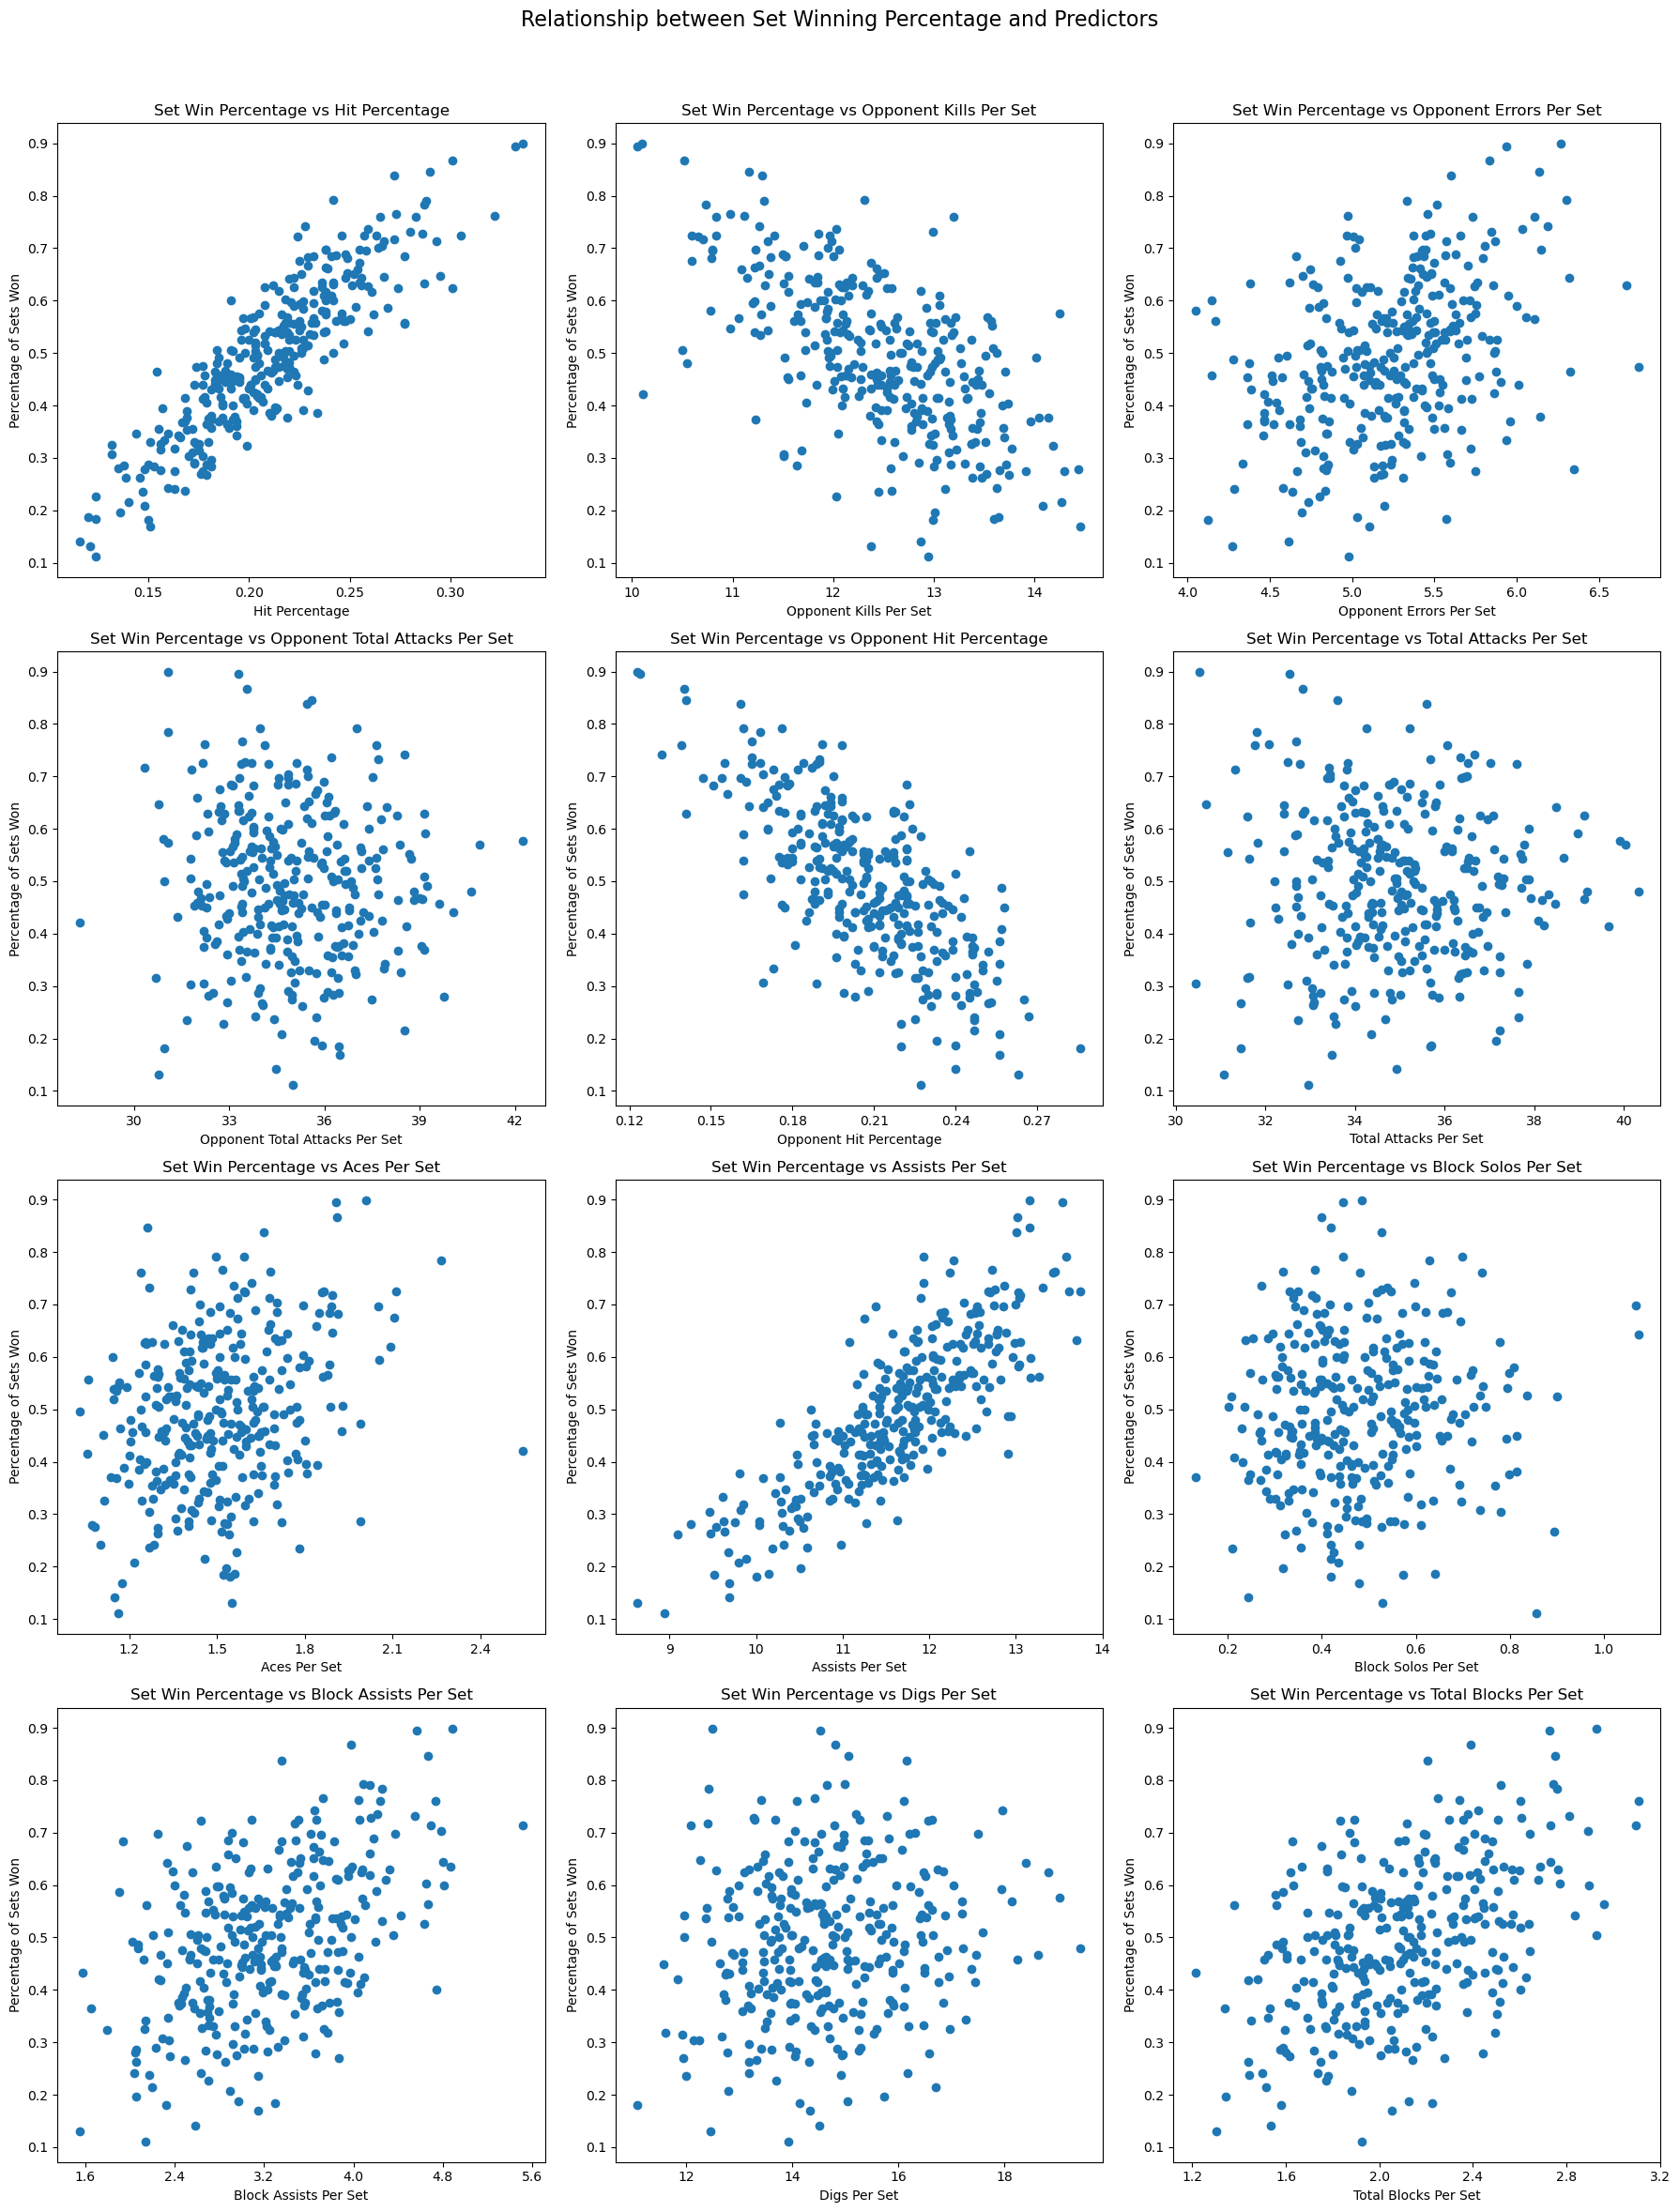

In [52]:
# Initialize Predictor List
predictor_list = [
    "Hit Percentage", "Opponent Kills Per Set", "Opponent Errors Per Set", "Opponent Total Attacks Per Set", "Opponent Hit Percentage", 
    "Total Attacks Per Set", "Aces Per Set", "Assists Per Set", "Block Solos Per Set", "Block Assists Per Set",
    "Digs Per Set", "Total Blocks Per Set",
]

# Set up the grid for subplots: 3 columns and 4 rows
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
fig.suptitle("Relationship between Set Winning Percentage and Predictors", fontsize=16)

# Loop over each predictor and create a plot
for i, predictor in enumerate(predictor_list):
    row, col = divmod(i, 3)  # Determine the subplot's row and column
    ax = axes[row, col]
    ax.scatter(team_stats[predictor], team_stats['Set_Win_Percentage'])
    ax.set_title(f'Set Win Percentage vs {predictor}')
    ax.set_ylabel("Percentage of Sets Won")
    ax.set_xlabel(predictor)
    ax.xaxis.set_major_locator(MaxNLocator(6))  # Adjust the number (e.g., 6) as needed

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to avoid overlap with suptitle
plt.show()

<a id="vis-features-histogram"></a>
## Visualizing Features vs Set Win Percentage (Histograms and Boxplots))
[Return to contents](#contents)

We realized that `Set_Win_Percentage` doesn't directly translate into sets won, so we decided to use histograms and box plots to better understand the relationship between these predictors and the sets won. Instead of directly attempting to predict who is going to win the championship, we are scaling down and trying to predict which team would win a set when teams are matched up. In this case, `Lose` means a team has a probability of 0.4 or less of winning the set, `Win` means having a probability of 0.6 or greater of winning the set, and `Neutral` is in between.

In some cases, we felt histograms served better to convey the information we wanted from the data. In other cases, box plots were sufficient. Now, most of the relationships agree with our intuition: sets are more likely to be won when a team's important statistics are greater and their opponent's important statistics are lower. Though less pronounced compared to previously, there are some relationships that, at initial glance, seem counterintuitive—once again because there appears to be no correlation where we might expect one.


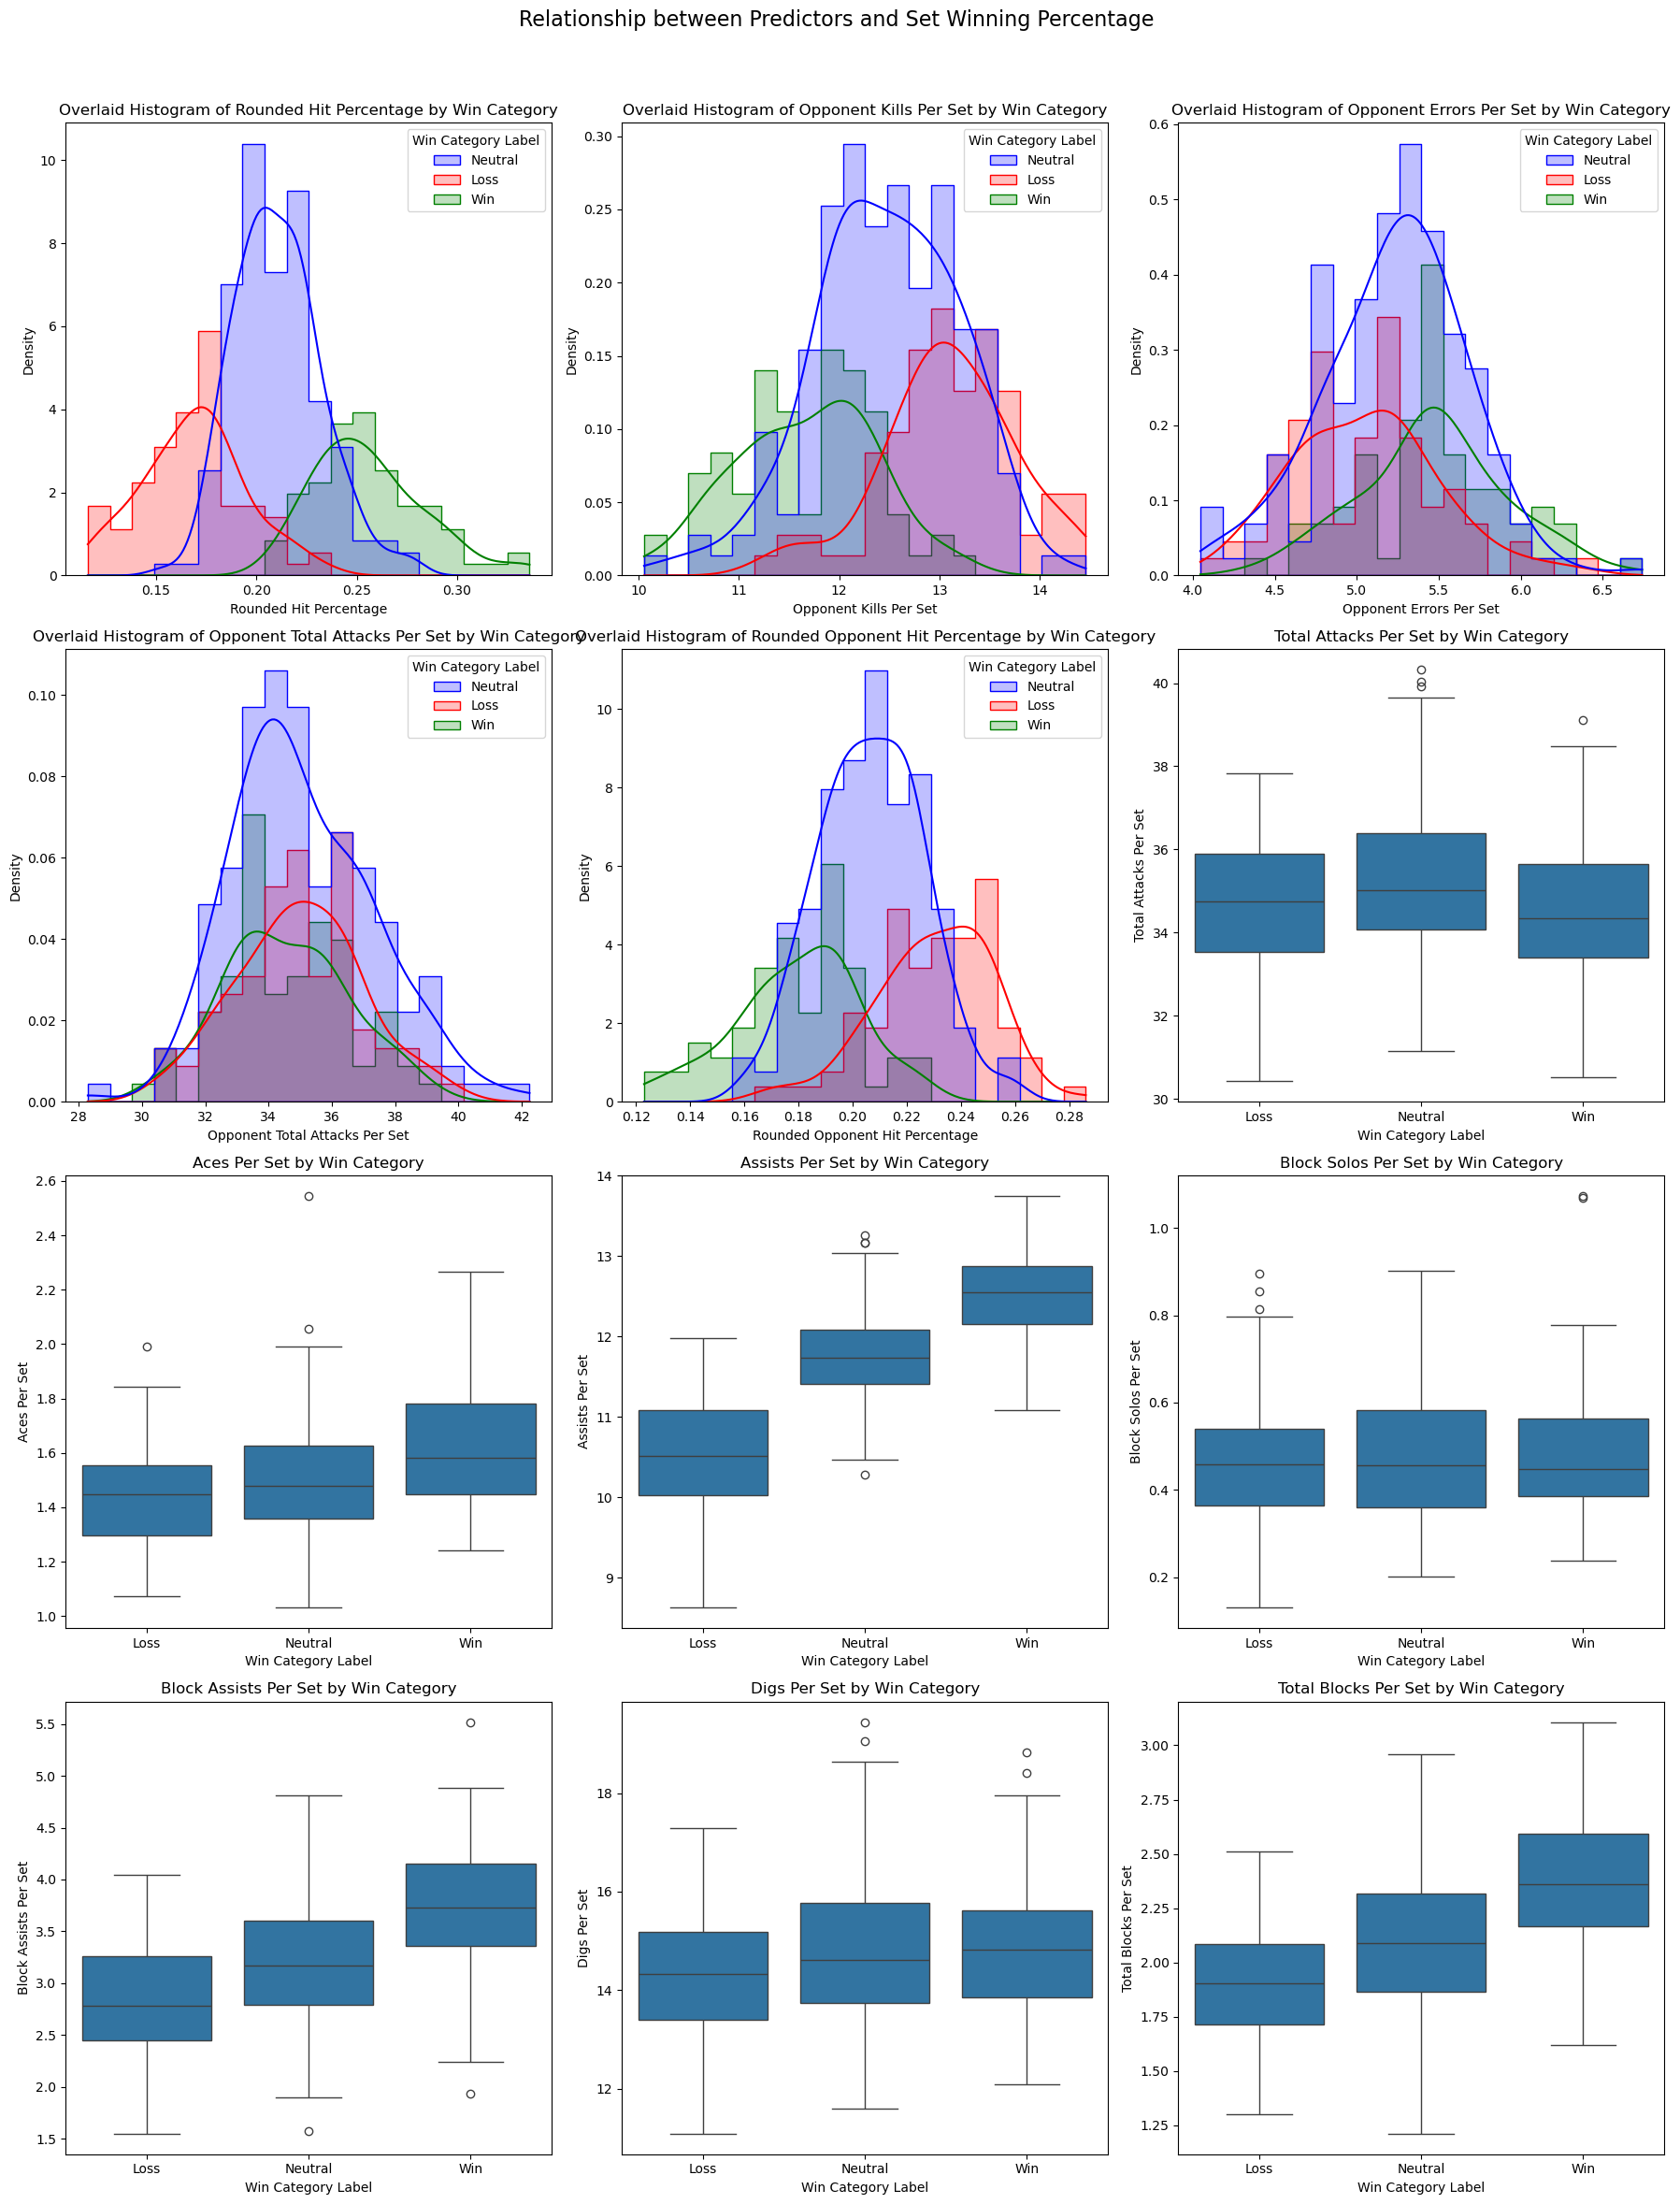

In [55]:
# Function to round to the nearest specified increment using Decimal for precision
def round_to_nearest(x, increment='0.025'):
    return float(Decimal(str(x)).quantize(Decimal(increment), rounding=ROUND_HALF_UP))

# Apply rounding to the percentage predictors
team_stats['Rounded Hit Percentage'] = team_stats['Hit Percentage'].apply(lambda x: round_to_nearest(x))
team_stats['Rounded Opponent Hit Percentage'] = team_stats['Opponent Hit Percentage'].apply(lambda x: round_to_nearest(x))

# Replace numeric win labels with descriptive text labels for plotting
team_stats['Win Category Label'] = team_stats['Win_Category'].replace({-1: "Loss", 0: "Neutral", 1: "Win"})

# Initialize Predictor List
predictor_list = [
    "Rounded Hit Percentage", "Opponent Kills Per Set", "Opponent Errors Per Set", "Opponent Total Attacks Per Set", "Rounded Opponent Hit Percentage", 
    "Total Attacks Per Set", "Aces Per Set", "Assists Per Set", "Block Solos Per Set", "Block Assists Per Set",
    "Digs Per Set", "Total Blocks Per Set",
]

# Define a custom palette with the specified colors for each category
custom_palette = {"Loss": "red", "Neutral": "blue", "Win": "green"}

# Set up the grid for subplots: 3 columns and 4 rows
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
fig.suptitle("Relationship between Predictors and Set Winning Percentage", fontsize=16)

# Loop over each predictor and create a plot
for i, predictor in enumerate(predictor_list):
    row, col = divmod(i, 3)  # Determine the subplot's row and column
    ax = axes[row, col]
    
    if i < 5:  # First 5 predictors use histograms
        sns.histplot(data=team_stats, x=predictor, hue="Win Category Label", discrete=False, bins=20, kde=True, 
                     element="step", stat="density", common_norm=True, ax=ax, palette=custom_palette)
        ax.set_title(f'Overlaid Histogram of {predictor} by Win Category')
        ax.set_xlabel(predictor)
        ax.set_ylabel('Density')
        
    else:  # Last 7 predictors use boxplots
        sns.boxplot(data=team_stats, x="Win Category Label", y=predictor, ax=ax, order=["Loss", "Neutral", "Win"])
        ax.set_title(f'{predictor} by Win Category')
        ax.set_ylabel(predictor)

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to avoid overlap with suptitle
plt.show()


<a id="step1"></a>
## Split Train / Test Data
[Return to contents](#contents)

Our favorite pre-processing step. As we don't have a 'test' data set (because the 2024 NCAA Division I Women's Volleyball Championship hasn't happend yet), we are applying train-test splits to create models we can be confident in.

In [ ]:
# Read in the final constructed regular season dataset. Leaving NCAA as the test set for now
regular_proc_df = pd.read_csv('data/regular_proc.csv')
regular_proc_df.head(3)


,Date,Team 1,Team 1 Score,Team 2,Team 2 Score,Win_Indicator,Team_1:Sets Played,Team_1:Hit Percentage,Team_1:Wins,Team_1:Losses,...,Team_2:Total Attacks Per Set,Team_2:Aces Per Set,Team_2:Assists Per Set,Team_2:Block Solos Per Set,Team_2:Block Assists Per Set,Team_2:Total Blocks Per Set,Team_2:Digs Per Set,Team_2:Opponent Kills Per Set,Team_2:Opponent Errors Per Set,Team_2:Opponent Total Attacks Per Set
0,2024-08-27,Nebraska,3,Kentucky,1,1,110.0,0.290,31.0,2.0,...,33.417476,1.893204,13.048544,0.378641,3.475728,2.116505,12.407767,10.708738,5.038835,30.330097
1,2024-08-27,Louisville,3,Wisconsin,1,1,112.0,0.265,27.0,5.0,...,33.821429,1.571429,13.035714,0.339286,5.517857,3.098214,14.794643,11.982143,5.866071,35.428571
2,2024-08-30,Stony Brook,3,Delaware St.,2,1,119.0,0.203,16.0,13.0,...,35.034783,1.782609,11.513043,0.547826,2.069565,1.582609,13.808696,10.547826,4.373913,32.000000


In [ ]:
## Step 1 - Split Train / Test Data

# Train/Test Split
X_train, X_val, y_train, y_val= train_test_split(
    regular_proc_df.drop(columns=['Win_Indicator', 'Date', 'Team 1', 'Team 1 Score', 'Team 2', 'Team 2 Score']),
    regular_proc_df['Win_Indicator'],
    test_size=0.2,
    random_state=27,
    shuffle=True,
    stratify=regular_proc_df['Win_Indicator'], # UNSURE ABOUT THIS BUT THINK IT IS GOOD
)

# 4. Modelling
<a id="modelling"></a>
[Return to contents](#contents)

<a id="step2"></a>
## Baseline Model (Majority Class)
[Return to contents](#contents)

Inspired by homework 4, we created the baseline model for completeness' sake, but it provides an obvious, trivial answer.  Because there are as many wins as losses in a season, it makes sense that there isn't a majority class (it's a 50/50 split), so accuracy based on majority class will be ~50%.  The reason for the slight offset (50.08% accurate) may be because we dropped some data in pre-processing to account for missingness.

In [ ]:
## Apply baseline model based on majority class categorization

# Find max class (Winners vs Losers)
y_train_win_count = sum(y_train == 1)
y_train_loss_count = sum(y_train == 0)
y_train_max_class = max(y_train_win_count, y_train_loss_count)

# Divide max class over total observations to get accuracy
baseline_train_acc = y_train_max_class / len(y_train)

# Print accuracy result
print(f"Baseline Model / Majority Class Train Accuracy: {baseline_train_acc:.4f}")

Baseline Model / Majority Class Train Accuracy: 0.5062


<a id="step3"></a>
## Basic Model (Logistic Regression)
[Return to contents](#contents)

To do the preprocessing, we are going to employ the `Pipeline` function to streamline that processing. Fortunately for us, all of the features are quantitative, so we don't have to worry about doing any one-hot-encoding for categorical variables. We chose to apply `StandardScaler` as the `LogisticRegression` estimator is sensitive to distance and scale. As we are using regularization, we are going to be using LASSO regularization, we are going to allow for interaction terms because we suspect there might be some that are informative (such as blocks and kills), but we also expect some of the predictors to be brought down to zero. We are going to find the best `C` first (as that is computationally expensive), then refit the model based on that best `C`. 

After doing so, we will print out the mean cross-validation accuracy, the train accuracy on the whole `X_train_scaled`, and then the test accuracy on `X_test_scaled`.

In [ ]:
# Define the pipeline
preprocess = Pipeline([
    ('scaler', StandardScaler()),
    ('interaction_terms', PolynomialFeatures(degree=2,
                                             include_bias=False,
                                             interaction_only=True))
])

# Fit and transform the training data
X_train_scaled = preprocess.fit_transform(X_train)

# Transform the test data
X_test_scaled = preprocess.transform(X_test)

# Generate new feature names
original_features = X_train.columns
poly = preprocess.named_steps['interaction_terms']
new_feature_names = poly.get_feature_names_out(original_features)

# Convert scaled data bac from numpy arrays to DataFrames with new column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=new_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=new_feature_names)

# Display results
display(X_train_scaled_df.head())
display(X_train_scaled_df.describe())

,Sets Played,Hit Percentage,Win Percentage,Opponent Hit Percentage,Kills Per Set,Errors Per Set,Total Attacks Per Set,Aces Per Set,Assists Per Set,Block Solos Per Set,...,Total Blocks Per Set_team2 Digs Per Set_team2,Total Blocks Per Set_team2 Opponent Kills Per Set_team2,Total Blocks Per Set_team2 Opponent Errors Per Set_team2,Total Blocks Per Set_team2 Opponent Total Attacks Per Set_team2,Digs Per Set_team2 Opponent Kills Per Set_team2,Digs Per Set_team2 Opponent Errors Per Set_team2,Digs Per Set_team2 Opponent Total Attacks Per Set_team2,Opponent Kills Per Set_team2 Opponent Errors Per Set_team2,Opponent Kills Per Set_team2 Opponent Total Attacks Per Set_team2,Opponent Errors Per Set_team2 Opponent Total Attacks Per Set_team2
0,2.776956,0.127562,-0.016583,0.405446,0.402869,0.480134,-0.114614,-0.460202,0.415005,0.400249,...,0.208174,-0.022545,3.461104,1.255760,-0.000992,0.152247,0.055239,-0.016488,-0.005982,0.918399
1,-0.472305,0.383975,-0.829502,0.477574,-0.121790,-0.934722,-0.381427,-0.024019,-0.472155,-0.278116,...,-0.007911,0.121749,0.042607,0.067517,-0.039284,-0.013748,-0.021785,0.211589,0.335293,0.117339
2,0.935708,-0.410905,0.250959,-0.712541,-0.295278,0.694456,-0.366720,0.106523,-0.334136,1.699195,...,0.041099,0.602377,0.361097,0.290576,0.044708,0.026800,0.021566,0.392805,0.316091,0.189482
3,-1.122158,-2.051949,-0.891242,-1.325630,-1.710971,1.939736,0.421079,-0.430031,-1.977845,1.699760,...,-0.575096,-0.022742,-0.715665,-0.648526,0.058072,1.827423,1.655984,0.072266,0.065486,2.060753
4,1.260634,0.537823,0.250959,0.008741,-0.046344,-1.354485,-0.201733,-0.545228,-0.183504,1.086822,...,-0.059129,-0.176706,0.092877,-0.084975,0.329116,-0.172983,0.158267,-0.516953,0.472975,-0.248595


,Sets Played,Hit Percentage,Win Percentage,Opponent Hit Percentage,Kills Per Set,Errors Per Set,Total Attacks Per Set,Aces Per Set,Assists Per Set,Block Solos Per Set,...,Total Blocks Per Set_team2 Digs Per Set_team2,Total Blocks Per Set_team2 Opponent Kills Per Set_team2,Total Blocks Per Set_team2 Opponent Errors Per Set_team2,Total Blocks Per Set_team2 Opponent Total Attacks Per Set_team2,Digs Per Set_team2 Opponent Kills Per Set_team2,Digs Per Set_team2 Opponent Errors Per Set_team2,Digs Per Set_team2 Opponent Total Attacks Per Set_team2,Opponent Kills Per Set_team2 Opponent Errors Per Set_team2,Opponent Kills Per Set_team2 Opponent Total Attacks Per Set_team2,Opponent Errors Per Set_team2 Opponent Total Attacks Per Set_team2
count,3.540000e+03,3.540000e+03,3.540000e+03,3.540000e+03,3.540000e+03,3.540000e+03,3.540000e+03,3.540000e+03,3.540000e+03,3.540000e+03,...,3540.000000,3540.000000,3540.000000,3540.000000,3540.000000,3540.000000,3540.000000,3540.000000,3540.000000,3540.000000
mean,-5.961333e-16,4.189994e-16,1.184238e-16,-8.751317e-16,1.811483e-16,-5.168496e-16,-1.882738e-15,-6.834458e-16,7.822995e-16,-3.492498e-16,...,-0.120715,-0.150550,0.729950,0.078945,0.192781,0.228633,0.852108,0.005960,0.571176,0.450872
std,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,...,0.939253,1.053652,1.137345,0.996021,1.056366,0.954779,1.369934,1.104821,1.171579,1.130746
min,-3.071714e+00,-2.462209e+00,-2.300986e+00,-3.020641e+00,-3.427585e+00,-2.796679e+00,-2.515035e+00,-2.144048e+00,-3.255781e+00,-2.311386e+00,...,-4.457822,-6.681370,-0.715665,-4.710027,-3.280574,-3.468699,-0.457645,-6.248317,-2.283217,-4.404747
25%,-6.889229e-01,-6.480875e-01,-7.626159e-01,-6.043483e-01,-5.374081e-01,-6.959648e-01,-6.586314e-01,-6.484790e-01,-5.219415e-01,-7.091020e-01,...,-0.449642,-0.516675,0.003868,-0.322990,-0.254982,-0.150141,0.040505,-0.412676,-0.036902,-0.088907
50%,6.923802e-02,-2.628595e-02,-6.293242e-03,8.740954e-03,8.421546e-02,-2.901490e-02,-4.560252e-02,-1.081625e-01,6.867111e-02,-1.744479e-01,...,0.001482,-0.032674,0.268713,0.024325,0.041182,0.073152,0.346715,-0.016488,0.202418,0.155371
75%,7.190902e-01,6.147465e-01,7.654646e-01,6.218302e-01,7.023120e-01,6.937242e-01,7.059222e-01,5.917617e-01,7.008018e-01,6.128942e-01,...,0.285875,0.259205,1.043824,0.446513,0.585547,0.535766,1.091567,0.350695,0.965774,0.719860
max,2.776956e+00,3.307083e+00,2.308980e+00,2.893867e+00,2.211379e+00,2.576013e+00,2.979657e+00,4.638658e+00,2.337752e+00,4.046307e+00,...,3.697880,4.760250,5.493115,5.643401,6.231914,6.133871,10.324485,5.548346,8.586149,6.043891


In [ ]:
# Get the best c from LogisticRegressionCV
Cs = np.logspace(-3, 3, 20)

# This shit took ~43 minutes to run
logreg = LogisticRegressionCV(Cs=Cs, 
                              cv=10, 
                              penalty='l1', 
                              solver='liblinear', 
                              scoring='accuracy', 
                              max_iter = 1000, 
                              random_state=109, 
                              n_jobs=-1).fit(X_train_scaled_df, y_train)

# Maybe we'll play with class weights later

/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/main/micromamba/envs/cs109a/

In [ ]:
# Get the best regularization parameter in case for future use
best_c = logreg.C_[0]
print(best_c)

logreg_train_acc = accuracy_score(y_train, logreg.predict(X_train_scaled_df))

# Calculate the mean cross-validation accuracy directly from the model since we've done CV already
logreg_cv_acc = np.max(logreg.scores_[1].mean(axis=0))

print(
    "\nThe classification accuracies for 'logreg' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logreg_train_acc, logreg_cv_acc)
)

# Should track both accuracy and l0g-loss (which might be better)
# eventually we want to calculate the probability of winning for a given team 1 against a given team 2


0.018329807108324356

The classification accuracies for 'logreg' are:

	Train	0.7743
	CV	0.7695


In [ ]:
# Create a DataFrame with predictors and coefficients
coef_df = pd.DataFrame({
    'Predictor': X_test_scaled_df.columns,
    'Coefficient': logreg.coef_[0]
})

# Sort the DataFrame by the absolute value of coefficients in descending order
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

# Reset the index for clean display
coef_df = coef_df.reset_index(drop=True)

# Display the top 20 coefficients
display(coef_df.head(10))

,Predictor,Coefficient
0,Win Percentage_team2,-0.762172
1,Win Percentage,0.744541
2,Hit Percentage,0.235808
3,Assists Per Set_team2,-0.196372
4,Hit Percentage_team2,-0.157240
5,Assists Per Set,0.148776
6,Block Assists Per Set_team2,-0.094119
7,Block Assists Per Set,0.081032
8,Sets Played Assists Per Set,-0.067724
9,Sets Played_team2 Errors Per Set_team2,-0.037695


<a id="interp"></a>
### Results Interpretation

As we are using a logistic regression, one way to represent our model is this:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \sum_{i=1}^p\beta_ix_i + \sum_{i=1}^p\sum_{j\neq i}\alpha_{i,j}x_ix_j $$ 

Where $Y=1$ means Team 1 wins the game, and $Y=0$ means Team 1 loses the game. We have now moved on from trying to determine who wins the set to who wins the game. Looking at the data, it appears that none of the predictors are statistically significant, but that doesn't mean they don't have predictive power. 

With the interaction term, interprability is more challenging, so let us ignore the interaction terms momentarily to exercise our intuition. In general, with a 1 unit increase in any of the predictors $x_i$, the log odds of that team winning increases by the $\beta_i$ associated with that predictor, holding all the other predictors constant. Now, including the interaction term, a 1 unit increase in any of the predictors $x_i$ will result in an increase of $\beta_i + \sum_{j\neq i}\alpha_{i,j}$ in the log odds. 

In this case, log odds can be intepreted as the probability of winning the game; a higher log odds equals a higher probability of winning the game.

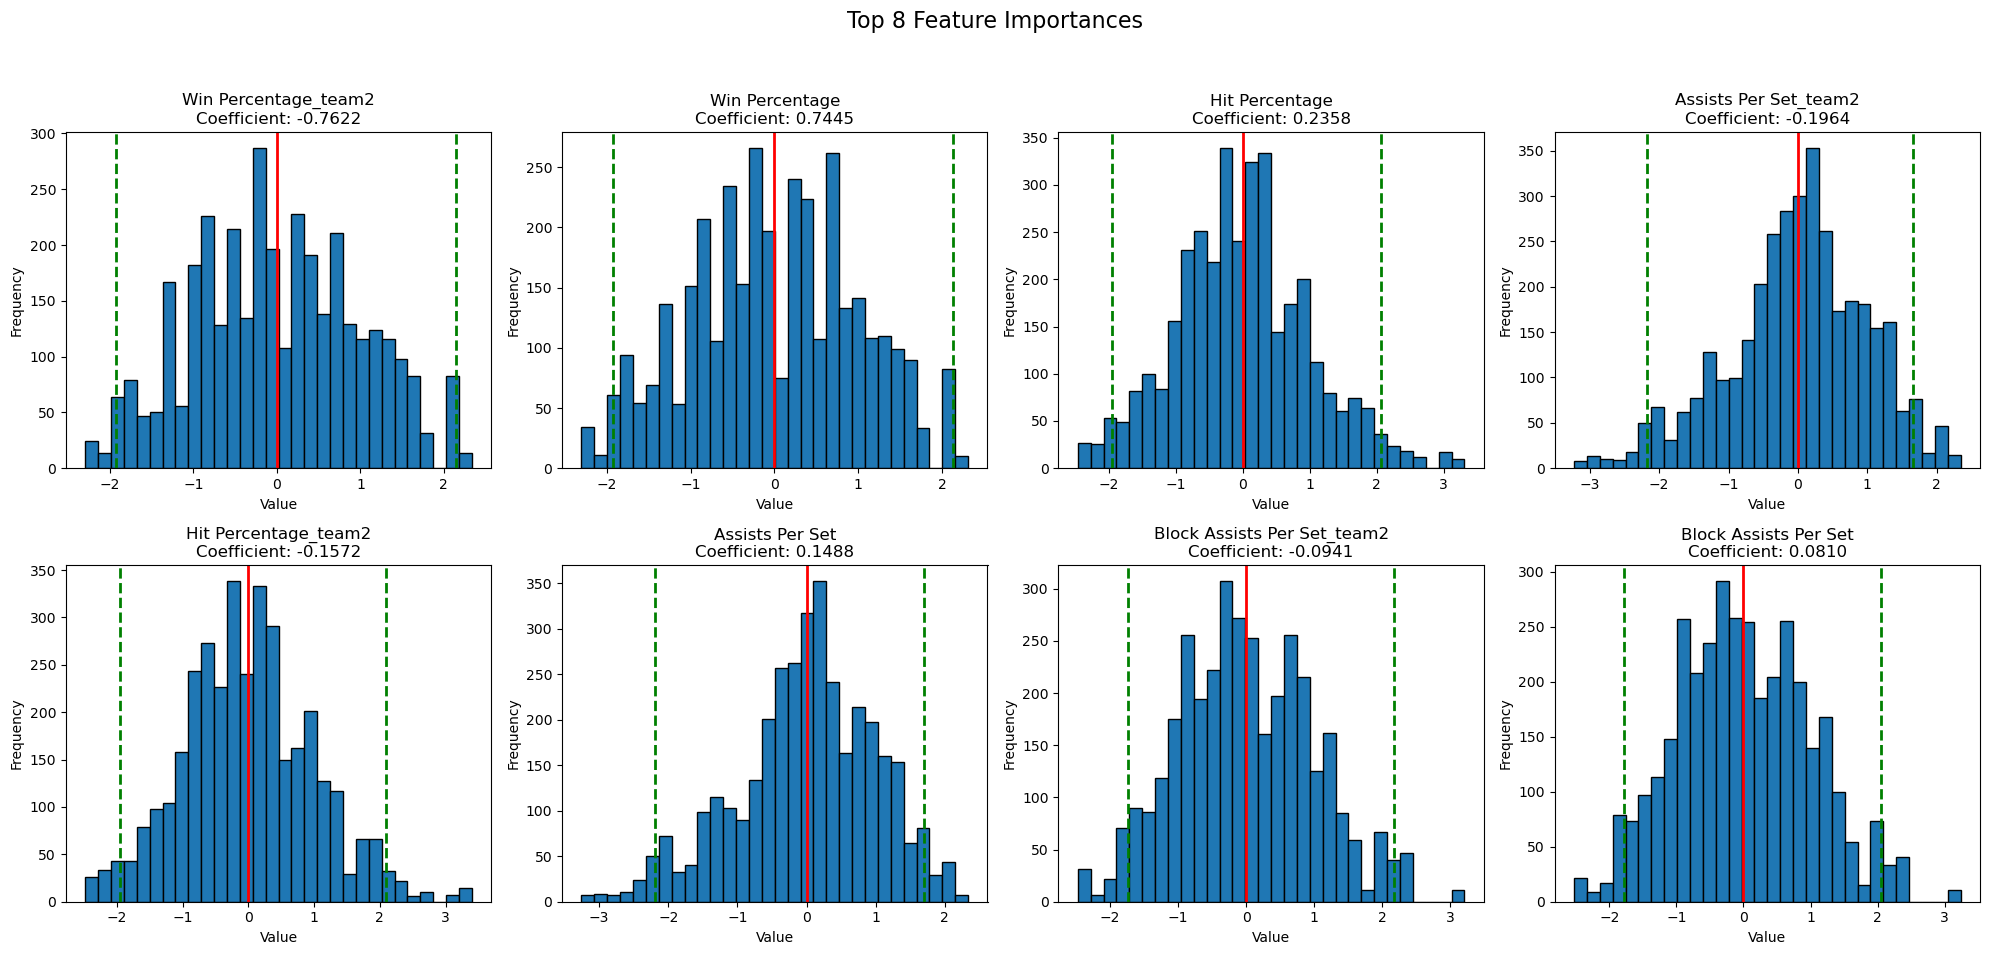

In [ ]:
# Sort by absolute value of coefficient and get top 8
top_8 = coef_df.iloc[(-coef_df['coefficient'].abs()).argsort()][:8]

# Set up the plot
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Top 8 Feature Importances', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (feature, coef) in enumerate(zip(top_8['feature'], top_8['coefficient'])):
    ax = axes[i]
    
    # Get the feature data
    feature_data = X_train_scaled_df[feature]
    
    # Create histogram
    ax.hist(feature_data, bins=30, edgecolor='black')
    
    # Add vertical line at 0
    ax.axvline(x=0, color='r', linestyle='-', linewidth=2)
    
    # Add vertical dashed lines at 2.5% and 97.5% percentiles
    percentile_2_5 = np.percentile(feature_data, 2.5)
    percentile_97_5 = np.percentile(feature_data, 97.5)
    ax.axvline(x=percentile_2_5, color='g', linestyle='--', linewidth=2)
    ax.axvline(x=percentile_97_5, color='g', linestyle='--', linewidth=2)
    
    # Set title and labels
    ax.set_title(f'{feature}\nCoefficient: {coef:.4f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<a id="step4"></a>
## Random Forest Model
[Return to contents](#contents)

In [ ]:
rf = RandomForestClassifier(
    max_depth = 10,
    n_estimators = 100,
    max_features = 'sqrt',
    random_state = 27,
    oob_score = True,
    n_jobs = -1
)


# Scaling doesn't matter on trees right?
rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
report = classification_report(y_val, y_val_pred)
print(report)


              precision    recall  f1-score   support

           0       0.78      0.75      0.76       441
           1       0.76      0.79      0.78       451

    accuracy                           0.77       892
   macro avg       0.77      0.77      0.77       892
weighted avg       0.77      0.77      0.77       892



In [ ]:
rf2 = GridSearchCV(estimator=RandomForestClassifier(random_state=27),
                  param_grid={'min_samples_split': [2,5,10,20],
                              'max_features': [2,5,8]},
                  cv=5)
rf2.fit(X_train, y_train)



/home/obonite/micromamba/envs/cs109a/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


              precision    recall  f1-score   support

           0       0.78      0.75      0.76       441
           1       0.76      0.79      0.78       451

    accuracy                           0.77       892
   macro avg       0.77      0.77      0.77       892
weighted avg       0.77      0.77      0.77       892



In [ ]:

y_pred = rf2.predict(X_train)
y_val_pred = rf2.predict(X_val)
report = classification_report(y_val, y_val_pred)
print(report)


              precision    recall  f1-score   support

           0       0.78      0.77      0.78       441
           1       0.78      0.79      0.79       451

    accuracy                           0.78       892
   macro avg       0.78      0.78      0.78       892
weighted avg       0.78      0.78      0.78       892



<a id="step5"></a>
## Final Pipeline Model (XGBoost)
[Return to contents](#contents)

We are now going to be experimenting with gradient boosting to see if we can get a performance improvement on who is going to win the set.

In [ ]:
# Now, we are going to try use a more complex model and experiment with Gradient Boosting
param_grid = {
    'n_estimators': 50,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 1.0,
    'colsample_bytree': 1.0
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=27),
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled_df, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Best cross-validation accuracy
best_accuracy = grid_search.best_score_
print(f"Best CV Accuracy: {best_accuracy:.4f}")


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best CV Accuracy: 0.7650
